In [17]:
import re
import logging
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

from re import sub
from time import time 
from unidecode import unidecode
from gensim.models import Word2Vec
from collections import defaultdict
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser

from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)


In [3]:
df_combined = pd.read_csv('data/combined_preprocessed_comments.csv')

In [4]:
df_combined['comment_no_stopwords'][1]

'protest non voters worst type privileged people. believing allowing worse outcome single issue get worse non vote exact opposite trying help because.'

In [5]:
df_cleaned = df_combined.dropna().drop_duplicates().reset_index(drop=True)

In [6]:
def text_to_word_list(text, remove_polish_letters):
    ''' Pre process and convert texts to a list of words 
    method inspired by method from eliorc github repo: https://github.com/eliorc/Medium/blob/master/MaLSTM.ipynb'''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = text.split()

    return text 

In [7]:
df_cleaned['comment_no_stopwords_list'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))
df_cleaned['comment_no_stopwords'] = df_cleaned['comment_no_stopwords'].apply(lambda x: text_to_word_list(x, unidecode))



In [8]:
df_model = df_cleaned.copy()

In [9]:
sent = [row for row in df_model['comment_no_stopwords']]
phrases = Phrases(sent, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[sent]
sentences[1]

INFO - 20:37:18: collecting all words and their counts
INFO - 20:37:18: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 20:37:18: collected 208185 token types (unigram + bigrams) from a corpus of 257100 words and 13315 sentences
INFO - 20:37:18: merged Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 20:37:18: Phrases lifecycle event {'msg': 'built Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.39s', 'datetime': '2024-12-05T20:37:18.678172', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 20:37:18: exporting phrases from Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 20:37:19: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<10504 phrases, min_count=1, threshold=10.0> from Phrases<208185 vocab, min_count=1, threshold=10.0, max_vocab_size=400000

['protest',
 'non_voters',
 'worst',
 'type',
 'privileged',
 'people',
 'believing',
 'allowing',
 'worse',
 'outcome',
 'single_issue',
 'get',
 'worse',
 'non',
 'vote',
 'exact_opposite',
 'trying_help',
 'because']

In [10]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Vocab creation time: {} mins'.format(round((time() - start) / 60, 2)))

INFO - 20:37:19: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2024-12-05T20:37:19.262490', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO - 20:37:19: collecting all words and their counts
INFO - 20:37:19: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 20:37:19: collected 30215 word types from a corpus of 223065 raw words and 13315 sentences
INFO - 20:37:19: Creating a fresh vocabulary
INFO - 20:37:19: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 11537 unique words (38.18% of original 30215, drops 18678)', 'datetime': '2024-12-05T20:37:19.776781', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 20:37:19: Word2Vec lifecycle event {'msg': 'effective_min_count=3 leaves 1962

Vocab creation time: 0.01 mins


In [11]:
start = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))

w2v_model.init_sims(replace=True)

INFO - 20:37:20: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 11537 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2024-12-05T20:37:20.114220', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'train'}
INFO - 20:37:21: EPOCH 0: training on 223065 raw words (68197 effective words) took 0.9s, 77384 effective words/s
INFO - 20:37:21: EPOCH 1: training on 223065 raw words (68729 effective words) took 0.7s, 93227 effective words/s
INFO - 20:37:22: EPOCH 2: training on 223065 raw words (68463 effective words) took 0.9s, 79656 effective words/s
INFO - 20:37:23: EPOCH 3 - PROGRESS: at 62.23% examples, 40055 words/s, in_qsize 2, out_qsize 1
INFO - 20:37:24: EPOCH 3: training on 223065 raw words (68439 effective words) took 1.6s, 43824 effective words/s
INFO - 20:37:25: EPOCH 4 - PROGRESS: at 46.24% examples, 32463 word

Time to train the model: 0.46 mins


In [12]:
w2v_model.save("data/word2vec.model")

INFO - 20:37:48: Word2Vec lifecycle event {'fname_or_handle': 'data/word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2024-12-05T20:37:48.081293', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'saving'}
INFO - 20:37:48: not storing attribute cum_table
INFO - 20:37:48: saved data/word2vec.model


In [13]:
df_model_export = df_model.copy()
df_model_export['old_comment_no_stopwords'] = df_model_export['comment_no_stopwords']
df_model_export.old_comment_no_stopwords = df_model_export.old_comment_no_stopwords.str.join(' ')
df_model_export['comment_no_stopwords'] = df_model_export['comment_no_stopwords'].apply(lambda x: ' '.join(bigram[x]))

df_model_export.to_csv("data/cleaned_comments_preprocessed.csv", index=False)

In [14]:
word_vectors = Word2Vec.load("data/word2vec.model").wv

INFO - 20:37:49: loading Word2Vec object from data/word2vec.model
INFO - 20:37:49: loading wv recursively from data/word2vec.model.wv.* with mmap=None
INFO - 20:37:49: setting ignored attribute cum_table to None
INFO - 20:37:50: Word2Vec lifecycle event {'fname': 'data/word2vec.model', 'datetime': '2024-12-05T20:37:50.196005', 'gensim': '4.3.3', 'python': '3.11.9 (main, Apr 19 2024, 11:44:45) [Clang 14.0.6 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'loaded'}


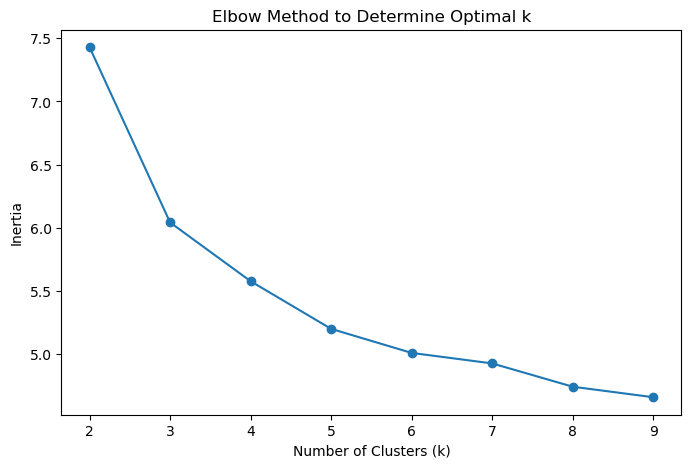

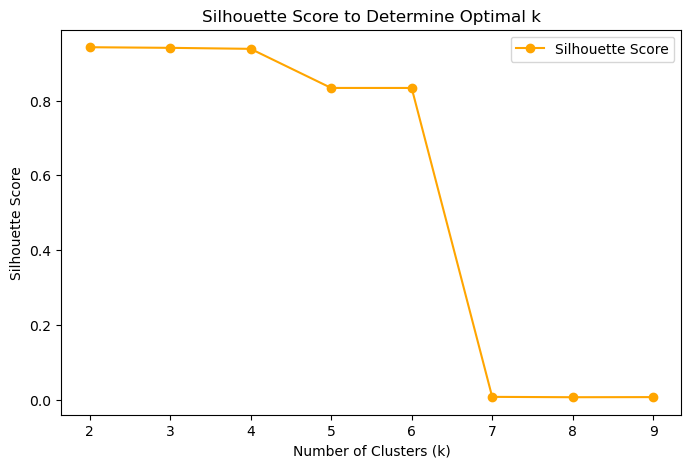

In [20]:
# Range of k clusters
k_values = range(2, 10)
inertia = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X=word_vectors.vectors.astype('double')) 
    inertia.append(kmeans.inertia_)

    # Compute silhouette score
    labels = kmeans.labels_
    silhouette = silhouette_score(word_vectors.vectors.astype('double'), labels)
    silhouette_scores.append(silhouette)

# Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o', color='orange', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to Determine Optimal k')
plt.legend()
plt.show()

In [ ]:
silhouette_scores

In [31]:
for k in range(len(k_values)):
    print(f"Silhoutte score for {k+2} clusters: {silhouette_scores[k]}")

Silhoutte score for 2 clusters: 0.9425841565792553
Silhoutte score for 3 clusters: 0.9409315526601614
Silhoutte score for 4 clusters: 0.9382492606551404
Silhoutte score for 5 clusters: 0.8336674323526853
Silhoutte score for 6 clusters: 0.8336250202560299
Silhoutte score for 7 clusters: 0.007356261361530736
Silhoutte score for 8 clusters: 0.006394703633103387
Silhoutte score for 9 clusters: 0.006712492030138957


In [21]:
model = KMeans(n_clusters=5, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [29]:
word_vectors.similar_by_vector(model.cluster_centers_[4], topn=50, restrict_vocab=None)

[('russia_ukraine', 0.9995020627975464),
 ('treatment_uighurs', 0.9989864826202393),
 ('domestic_policy', 0.9987557530403137),
 ('war_china', 0.9985295534133911),
 ('us_elections', 0.998095691204071),
 ('situation_kashmir', 0.9973621964454651),
 ('0_video', 0.9953229427337646),
 ('limited_to', 0.9950907230377197),
 ('examples_include', 0.9912188053131104),
 ('post_download', 0.9899893999099731),
 ('risk_banned', 0.9876947402954102),
 ('redditsave_viddit', 0.9845572710037231),
 ('sub_topic', 0.9796046018600464),
 ('red_!', 0.9744341373443604),
 ('topic_content', 0.9731457233428955),
 ('tolerated_stay', 0.9698495864868164),
 ('etc_warning', 0.965540885925293),
 ('thanks_posting', 0.9599818587303162),
 ('hate_speech', 0.9581995010375977),
 ('bot_action', 0.9501994848251343),
 ('islamophobia_trolling', 0.9499930143356323),
 ('hasbara_bigotry', 0.9405102133750916),
 ('genocide_denial', 0.9394720196723938),
 ('zionist_propaganda', 0.9390925765037537),
 ('!_bot', 0.9367614984512329),
 ('perfo

In [244]:
positive_cluster_index = 0
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [245]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [246]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [247]:
words[['words', 'sentiment_coeff']].to_csv('data/sentiment_dictionary.csv', index=False)

In [248]:
sentiment_map = pd.read_csv('data/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

In [271]:
final_df = pd.read_csv("data/cleaned_comments_preprocessed.csv")
df_weighting = final_df.copy()
df_weighting = df_weighting[df_weighting['comment_no_stopwords'].str.len()>0]
df_weighting = df_weighting.reset_index(drop=True)

tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(df_weighting['comment_no_stopwords'])
features = pd.Series(tfidf.get_feature_names_out())


/Users/kalleleander/opt/anaconda3/envs/py311/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [272]:
missing_words =pd.Series(['every_single'])
features = pd.concat([features, missing_words]).reset_index(drop=True)
transformed = tfidf.transform(df_weighting['comment_no_stopwords'])

In [274]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    
    inspired  by function from this wonderful article: 
    https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34
    
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    words = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y: dictionary.get(y, 0), x['comment_no_stopwords'].split()))

In [275]:
%%time
replaced_tfidf_scores = df_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1) # this step takes around 3-4 minutes minutes to calculate

CPU times: user 4.3 s, sys: 128 ms, total: 4.43 s
Wall time: 5.54 s


In [276]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [277]:
replaced_closeness_scores = df_weighting['comment_no_stopwords'].apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [282]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, df_weighting['comment_no_stopwords']]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'sentence']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)

In [283]:
replacement_df['sentiment_score_unsupervised'] = replacement_df['sentiment_coeff'].apply(np.mean)

In [286]:
df_final = pd.read_csv("data/cleaned_comments_preprocessed.csv")
df_final['sentiment_score_unsupervised'] = replacement_df['sentiment_score_unsupervised']

df_final.to_csv('data/cleaned_comments_preprocessed.csv', index=False)

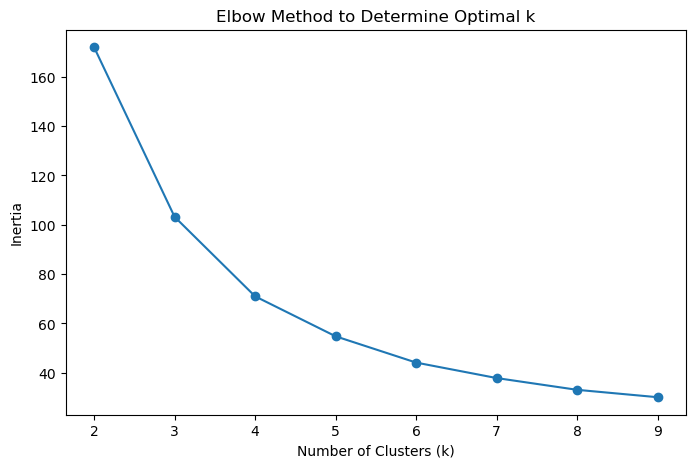

In [ ]:
# Range of k clusters
k_values = range(2, 10)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)  # Use PCA-reduced embeddings for faster computation
    inertia.append(kmeans.inertia_)

# Plot inertia vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal k')
plt.show()


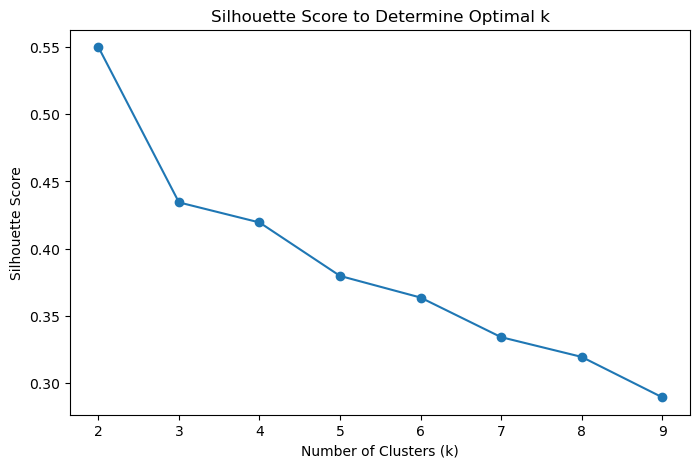

In [ ]:
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    silhouette_scores.append(score)

# Plot silhouette score vs. k
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score to Determine Optimal k')
plt.show()

In [ ]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=word_vectors.vectors)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]

Cluster 0: ['israel', 'people', 'would', 'like', 'hamas', 'us', 'one', 'even', 'get', 'palestine']


In [ ]:
np.bincount(labels)

array([10998,    44])

In [ ]:
centroids = kmeans.cluster_centers_

# Find most similar words to each centroid
cluster_similar_words = {
    cluster: word_vectors.similar_by_vector(centroid, topn=10, restrict_vocab=None)
    for cluster, centroid in enumerate(centroids)
}

# Analyze the top words in each cluster
for cluster, words in cluster_similar_words.items():
    print(f"Cluster {cluster}: {[word[0] for word in words]}")

Cluster 0: ['local,', 'approve', 'policies,', 'sought', 'trouble.', 'extends', 'senses', '66', 'object', 'regardless.']
Cluster 1: ['local,', 'approve', 'policies,', 'sought', 'trouble.', 'extends', 'senses', '66', 'regardless.', 'object']
